# Projeto

Um trabalho desenvolvido na disciplina de Machine Learning (Estatística-UFSM) para aplicar as técnicas de ML visando predizer o vencedor da Copa do Mundo FIFA 2022, simulando partida a partida da fase de grupo até a grande final.

Utilizando dois datasets como fontes [International football results from 1872 to 2022](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) e [FIFA World Ranking 1992-2022](https://www.kaggle.com/datasets/cashncarry/fifaworldranking).

A estruturação do feature engineering presente nesse trabalho foi desenvolvida em [Soccer World Cup 2018 Winner](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). No entanto, foi realizado uma metodologia buscando uma acurácia melhor, adicionando pouca complexidade (covariáveis) ao modelo. 

Os modelos utilizados são para classificação binária para simplificação da modelagem e estruturação das variáveis, assim os modelos são para predizer vitória/derrota, com as partidas que foram empates sendo excluídas da modelagem. A probabilidade de vencer a partida é dada como a média de vencer a partida dentro de casa e fora de casa (pois na copa do mundo não tem vantagem de mandante).

O autor da modelagem para a previsão do vencedor da Copa do Mundo de 2018, que utilizei como base desse projeto, também realizou a modelagem para a Copa de 2022, estando disponível em [Predicting FIFA 2022 World Cup with ML](https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml).

In [1]:
import numpy as np 
import pandas as pd
import re 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
#import networkx as nx
#from networkx.drawing.nx_pydot import graphviz_layout
from utils.modelling_functions import analyze, scraping, simulation_groups, simulation_quartas

# Modelagem 

Após a construção das variáveis e sua avaliação, nós temos os dataset prontos com colunas com poder preditivo interessante (como visto em feature_analysis), nós podemos começar a modelagem.

Nós iremos testar 3 modelos: Regressão Logística, Random Forest e Gradient Boosting. Selecionaremos o modelo com melhor Recall/Revocação/Sensibilidade.

In [2]:
model_db = pd.read_csv('data/modelling_dataset.csv')
team_stats_raw = pd.read_csv('data/team_stats_by_match.csv')

In [3]:
X = model_db.iloc[:, 3:]
y = model_db[["result"]]

In [4]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1],
            "min_samples_split": [3, 5],
            "min_samples_leaf": [5, 7, 10],
            "max_depth":[3, 5],
            "max_features":["sqrt"],
            "n_estimators":[200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1, verbose = False)

In [5]:
gb_cv.fit(X.values, np.ravel(y))

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [3, 5], 'n_estimators': [200]},
             verbose=False)

In [6]:
gb = gb_cv.best_estimator_

In [7]:
print(gb_cv.best_params_)

{'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 200}


In [8]:
params_rf = {
            "min_samples_split": [14, 15, 17],
            "min_samples_leaf": [5],
            "max_depth":[8],
            "max_features":["log2", "sqrt"],
            "max_leaf_nodes": [100],
            "criterion": ["entropy", "log_loss"],
            "n_estimators":[500]
         } 

rf = RandomForestClassifier(random_state=5)

rf_cv = GridSearchCV(rf, params_rf, cv = 5, n_jobs = -1, verbose = False)

rf_cv.fit(X.values, np.ravel(y))

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'log_loss'], 'max_depth': [8],
                         'max_features': ['log2', 'sqrt'],
                         'max_leaf_nodes': [100], 'min_samples_leaf': [5],
                         'min_samples_split': [14, 15, 17],
                         'n_estimators': [500]},
             verbose=False)

In [9]:
rf = rf_cv.best_estimator_

In [10]:
params_rlog = {"C": np.arange(0.01,0.5,0.05), "penalty":["l1","l2", "elasticnet", "none"], "max_iter" : [10000]}# l1 lasso l2 ridge
rlog = LogisticRegression()
logreg_cv = GridSearchCV(rlog, params_rlog, cv=5, n_jobs = -1, verbose = False)
logreg_cv.fit(X.values, np.ravel(y))

c:\Users\aluga.com\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aluga.com\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aluga.com\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\aluga.com\repos\FIFA_WC_22_Prediction

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46]),
                         'max_iter': [10000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             verbose=False)

In [11]:
rlog = logreg_cv.best_estimator_
# # Predicting the Test set results
# y_pred = rf.predict(X_test)
# #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
# # reversefactor = dict(zip(range(3),definitions))
# # y_test = np.vectorize(reversefactor.get)(y_test)
# # y_pred = np.vectorize(reversefactor.get)(y_pred)
# # Making the Confusion Matrix
# pd.crosstab(np.ravel(y_test), y_pred)

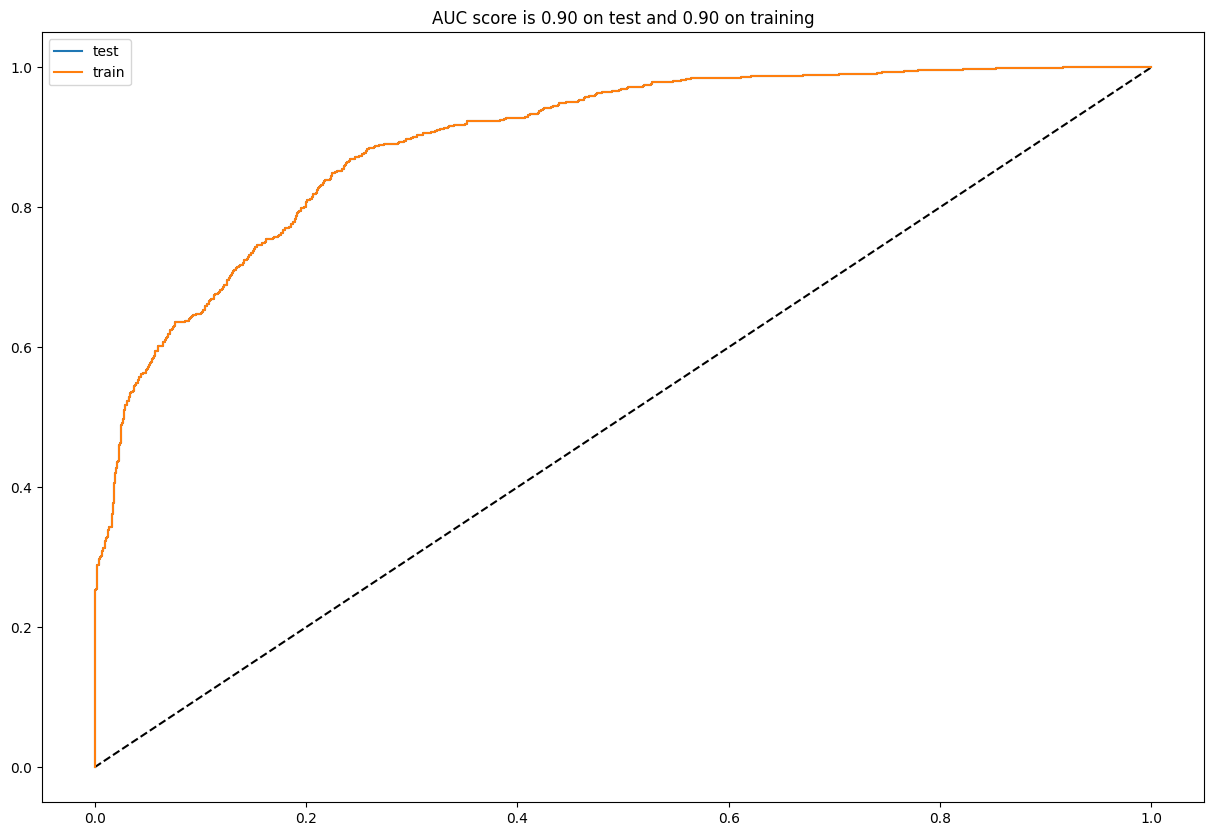

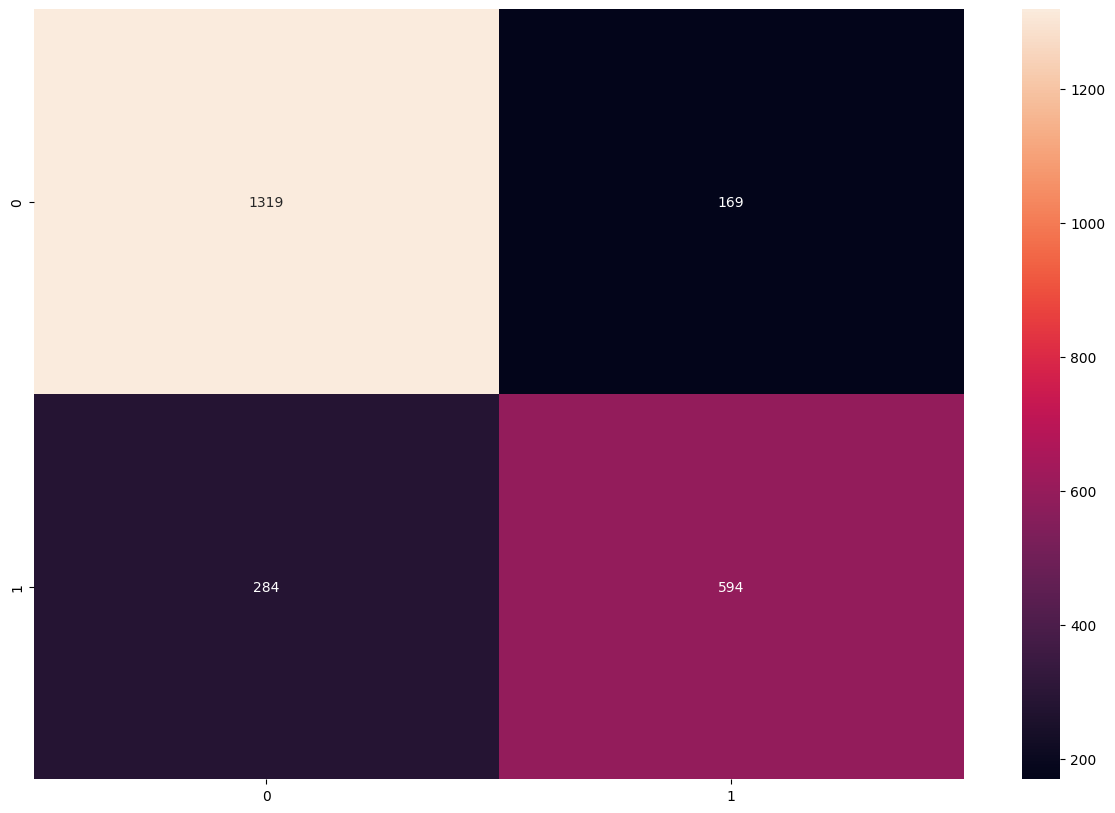

In [12]:
analyze(gb, y, y, X, X)

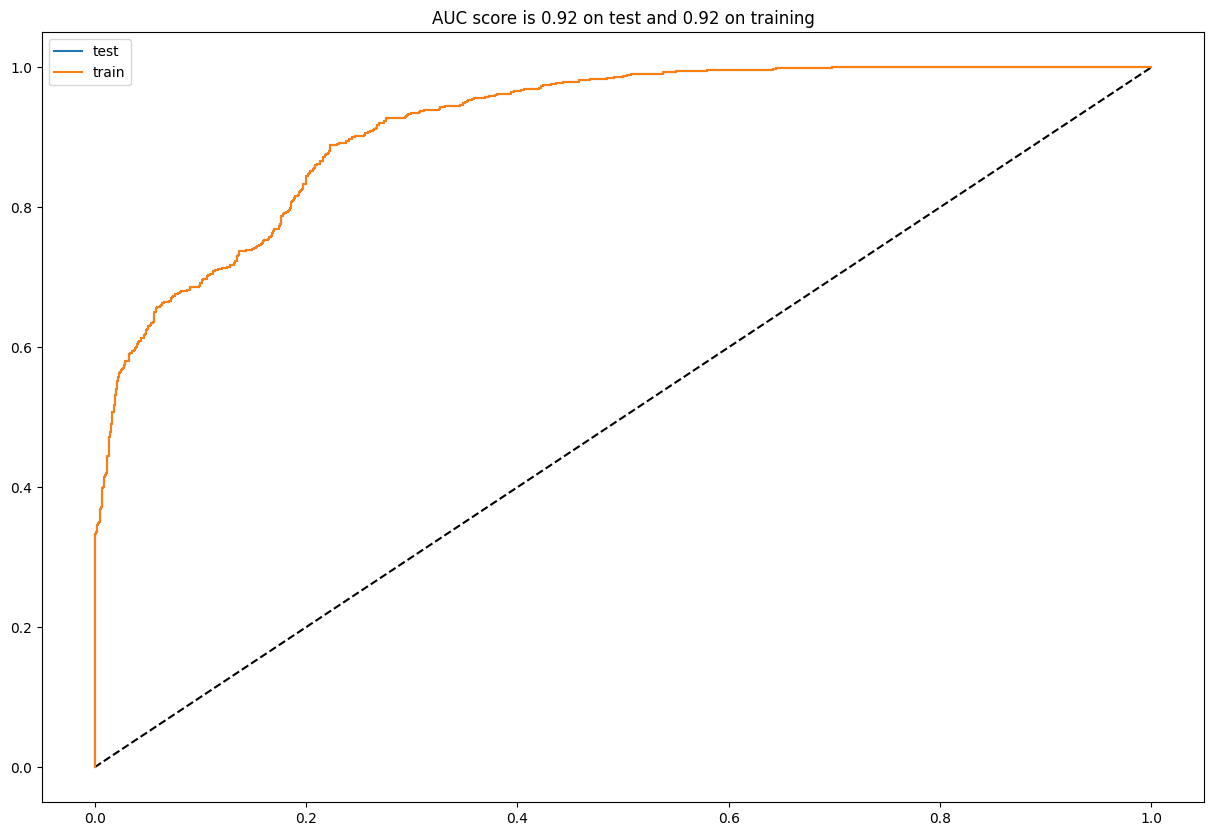

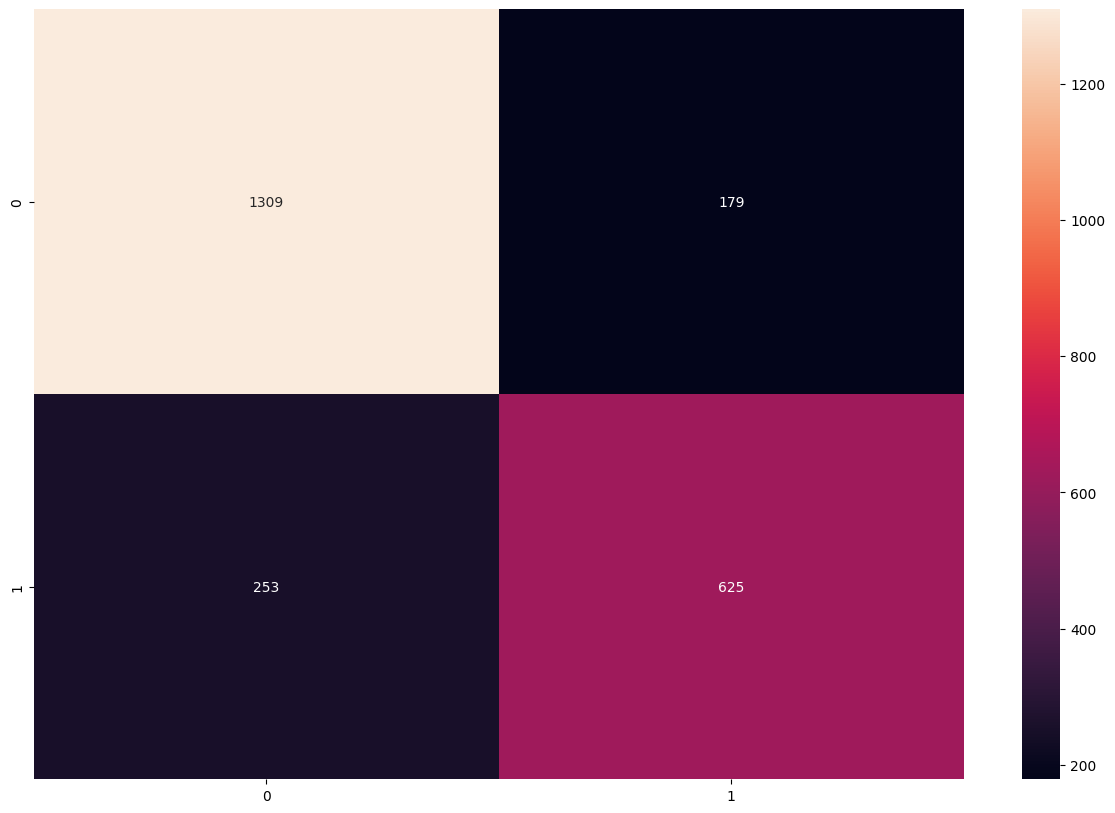

In [13]:
analyze(rf, y, y, X, X)

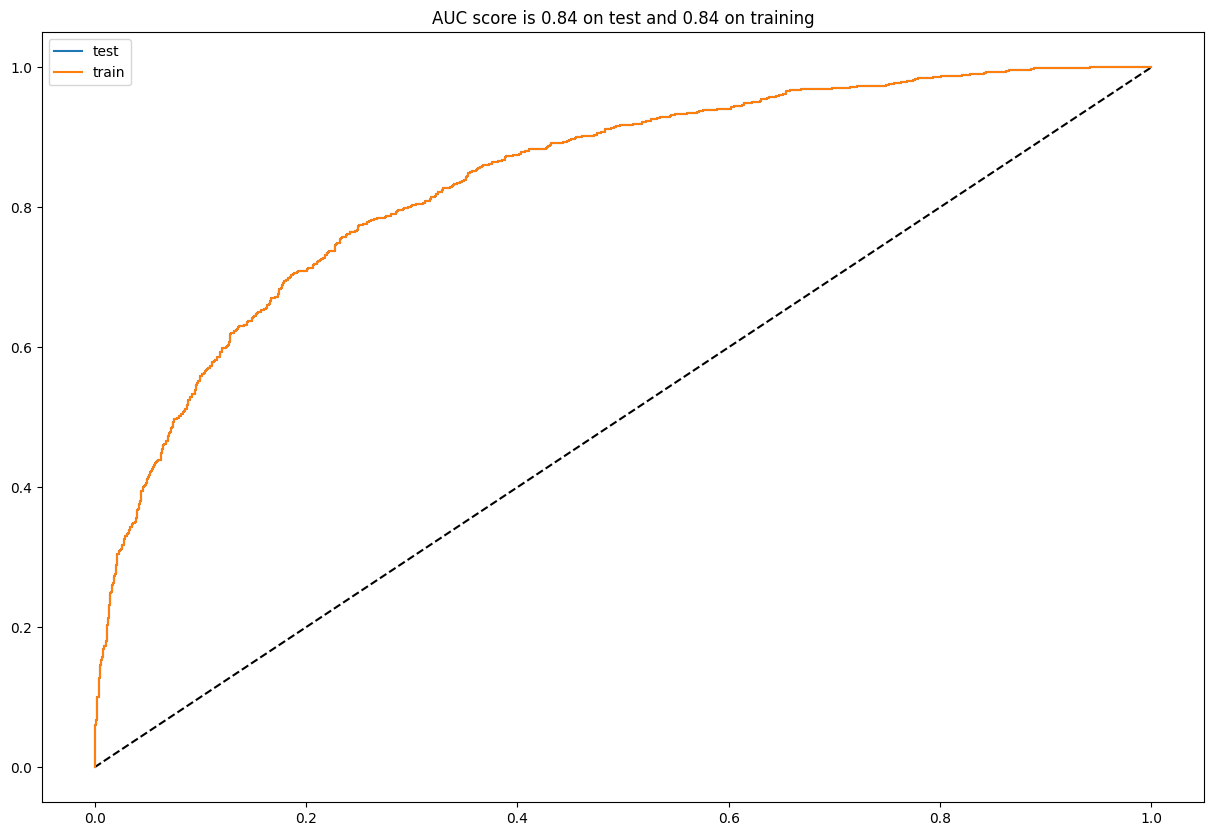

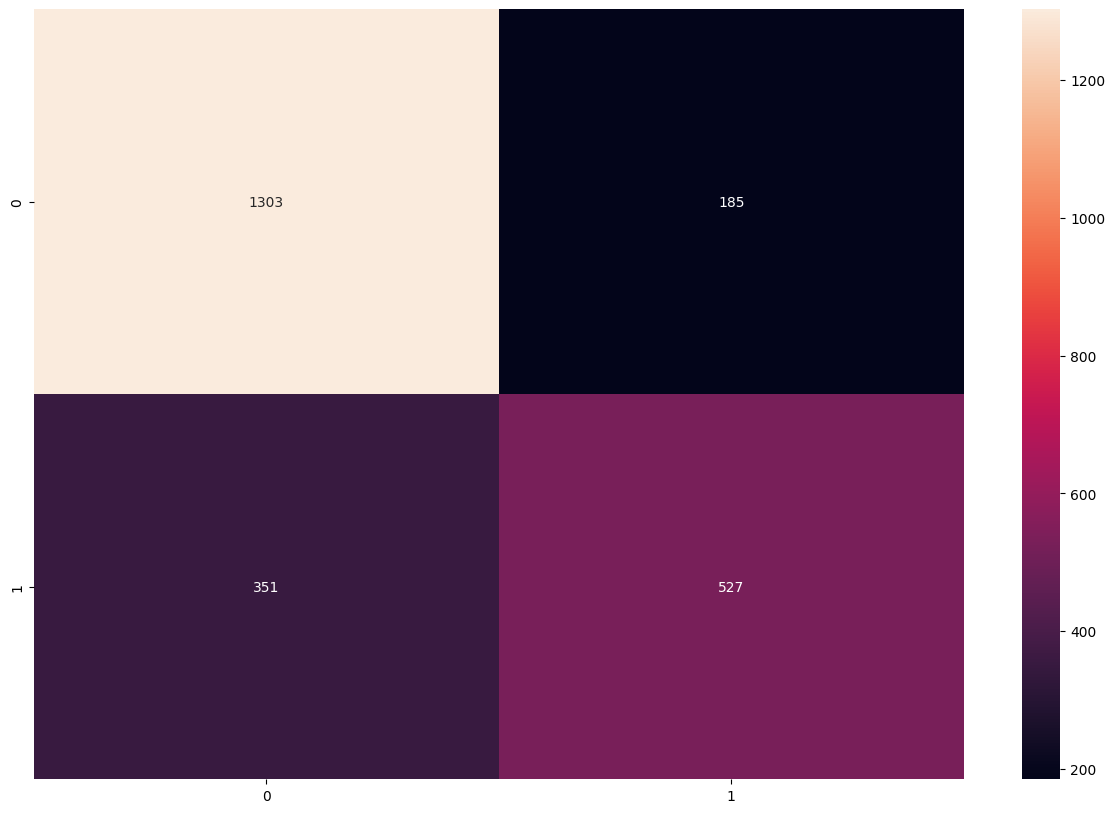

In [14]:
analyze(rlog, y, y, X, X)

O modelo que irei escolher para a "previsão oficial" será o modelo de Random Forest, pois os outros ficaram mais underfittados ou menos constantes em sementes diferentes. 

# Simulação da Copa

Para podermos simularmos os jogos, primeiramente vamos realizar um Web Scraping do Wikipédia para conseguirmos pegar os grupos, times e partidas da primeira fase. 

In [15]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games['score'].mean()
    team_1_goals_l5 = last5['score'].mean()
    team_1_goals_suf = past_games['suf_score'].mean()
    team_1_goals_suf_l5 = last5['suf_score'].mean()
    team_1_rank_suf = past_games['rank_suf'].mean()
    team_1_rank_suf_l5 = last5['rank_suf'].mean()
    team_1_gp_rank = past_games['points_by_rank'].mean()
    team_1_gp_rank_l5 = last5['points_by_rank'].mean()
    team_1_points_by_classification = past_games['points_by_classification'].mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5, team_1_points_by_classification]

In [16]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    dif_points_by_classification = team_1[9] - team_2[9]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0, dif_points_by_classification]

Agora com as funções ``find_stats()`` e ``find_features()`` podemos começar a simulação.

No entanto, temos que definir algumas regras como os datasets estão divididos em mandante e visitante, assim como na copa do mundo são sempre campos neutros, iremos simular a mesma partida invertendo os mandantes. 

Assim o empate será definido quando mudar o resultado de acordo com o mando de campo.

In [17]:
X.columns

Index(['rank_dif', 'goals_dif', 'goals_dif_l5', 'goals_suf_dif',
       'goals_suf_dif_l5', 'goals_per_ranking_dif', 'dif_rank_agst',
       'dif_rank_agst_l5', 'dif_points_rank', 'dif_points_rank_l5',
       'is_friendly_0', 'is_friendly_1', 'dif_points_by_classification'],
      dtype='object')

In [18]:
advanced_group = [
    'Netherlands',
    'Argentina',
    'Croatia',
    'Brazil',
    'England',  
    'France', 
    'Morocco', 
    'Portugal'
]

In [19]:
advanced_group = [['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Poland'],
 ['France', 'Australia'],
 ['Japan', 'Spain'],
 ['Morocco', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'South Korea']]

Praticamente não tivemos surpresas na frase de grupos, poderíamos dizer que as principais são os dois empates do Qatar com o Equador e principlamente com os Países Baixos, a classificação da Tunisia para no grupo da França, ao invés da Dinamarca e a classificação de Marrocos em grupo cheio de empates, com Bélgica e Marrocos se sobressaindo a Croácia e Canadá. 

In [20]:
advanced = advanced_group

In [21]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Poland'],
 ['France', 'Australia'],
 ['Japan', 'Spain'],
 ['Morocco', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'South Korea']]

In [22]:
playoffs = simulation_quartas(advanced, gb)

a
----------
Começando a simulação de  Quartas de Final
----------


Netherlands vs. Argentina: Argentina avança com probabilidade 53.69
Croatia vs. Brazil: Brazil avança com probabilidade 58.35
England vs. France: France avança com probabilidade 53.33
Morocco vs. Portugal: Portugal avança com probabilidade 59.27
a
----------
Começando a simulação de  Semi-Final
----------


Argentina vs. Brazil: Brazil avança com probabilidade 52.36
France vs. Portugal: France avança com probabilidade 56.71
a
----------
Começando a simulação de  Final
----------


Brazil vs. France: Brazil avança com probabilidade 54.44


In [23]:
# plt.figure(figsize=(15, 10))
# G = nx.balanced_tree(2, 3)


# labels = []


# for p in playoffs.keys():
#     for game in playoffs[p]:
#         label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
#         labels.append(label)
    
# labels_dict = {}
# labels_rev = list(reversed(labels))

# for l in range(len(list(G.nodes))):
#     labels_dict[l] = labels_rev[l]

# pos = graphviz_layout(G, prog='twopi')
# labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
# center  = pd.DataFrame(pos).mean(axis=1).mean()
    

# nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
# nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
#                         labels=labels_dict)
# texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
# pos_y = pos[0][1] + 55
# for text in reversed(texts):
#     pos_x = center
#     pos_y -= 75 
#     plt.text(pos_y, pos_x, text, fontsize = 18)

# plt.axis('equal')
# plt.show()

A previsão utilizando o modelo Gradient Boosting, prevê o Brasil como Hexa campeão. Com todas as partidas a partir das quartas sendo definidas nos detalhes, com probabilidades próximas ou menos a 0.6. Assim demonstrando a dificuldade e imprevisibilidade das partidas entre as favoritas. 

## Random forest

In [24]:
advanced_group = [['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Poland'],
 ['France', 'Australia'],
 ['Japan', 'Spain'],
 ['Morocco', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'South Korea']]

In [25]:
advanced = advanced_group

In [26]:
playoffs = simulation_quartas(advanced, rf)

a
----------
Começando a simulação de  Quartas de Final
----------


Netherlands vs. Argentina: Argentina avança com probabilidade 55.62
Croatia vs. Brazil: Brazil avança com probabilidade 62.41
England vs. France: France avança com probabilidade 51.96
Morocco vs. Portugal: Portugal avança com probabilidade 63.30
a
----------
Começando a simulação de  Semi-Final
----------


Argentina vs. Brazil: Brazil avança com probabilidade 52.35
France vs. Portugal: France avança com probabilidade 56.40
a
----------
Começando a simulação de  Final
----------


Brazil vs. France: Brazil avança com probabilidade 55.58


A Random Forest também prevê o hexa, mas com uma diferença mínima de apenas 0.40. O caminho para o Hexa, assim como o grupo da fase de entrada, deve ser o mais difícil da história, mas mesmo assim, os modelos prevém o Brasil como grande favorito.

## Regressão Logística

In [27]:
advanced = [['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Poland'],
 ['France', 'Australia'],
 ['Japan', 'Spain'],
 ['Morocco', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'South Korea']]

In [28]:
advanced = advanced_group

In [29]:
advanced

[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Poland'],
 ['France', 'Australia'],
 ['Japan', 'Spain'],
 ['Morocco', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'South Korea']]

In [30]:
playoffs = simulation_quartas(advanced, rlog)

a
----------
Começando a simulação de  Quartas de Final
----------


Netherlands vs. Argentina: Argentina avança com probabilidade 56.02
Croatia vs. Brazil: Brazil avança com probabilidade 70.42
England vs. France: England avança com probabilidade 52.94
Morocco vs. Portugal: Portugal avança com probabilidade 57.67
a
----------
Começando a simulação de  Semi-Final
----------


Argentina vs. Brazil: Brazil avança com probabilidade 55.80
England vs. Portugal: England avança com probabilidade 54.72
a
----------
Começando a simulação de  Final
----------


Brazil vs. England: Brazil avança com probabilidade 55.66


In [31]:
# plt.figure(figsize=(15, 10))
# G = nx.balanced_tree(2, 3)


# labels = []


# for p in playoffs.keys():
#     for game in playoffs[p]:
#         label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
#         labels.append(label)
    
# labels_dict = {}
# labels_rev = list(reversed(labels))

# for l in range(len(list(G.nodes))):
#     labels_dict[l] = labels_rev[l]

# pos = graphviz_layout(G, prog='twopi')
# labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
# center  = pd.DataFrame(pos).mean(axis=1).mean()
    

# nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
# nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
#                         labels=labels_dict)
# texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
# pos_y = pos[0][1] + 55
# for text in reversed(texts):
#     pos_x = center
#     pos_y -= 75 
#     plt.text(pos_y, pos_x, text, fontsize = 18)

# plt.axis('equal')
# plt.show()

Aparentemente todos os caminhos levam ao Hexa, com o Brasil conquistando o títulos nas três simulações. Destaca-se o número de empates na Regressão Logística e as poucas zebras que acontecem durante a Copa do Mundo (uma dificuldade nítida dos modelos de ML). Assim, o Brasil com um caminho muito difícil, o lado de mata-mata mais difícil e uma fase de grupo competitiva, consegue nas três previsões avançar sobre todos esse percalços e conquistar o Hexa.